In [1]:
import numpy as np
from itertools import combinations
import random

def generate_data(num_qubits, cardinality, num_samples):
    # Generate all possible binary vectors of length num_qubits with the given cardinality
    vectors = list(combinations(range(num_qubits), cardinality))
    
    # Convert combinations to binary vectors
    X = []
    for vec in vectors:
        binary_vec = [0] * num_qubits
        for idx in vec:
            binary_vec[idx] = 1
        X.append(binary_vec)
    
    # If the number of samples is less than the number of possible vectors, randomly sample
    if num_samples < len(X):
        X = random.sample(X, num_samples)
    
    # Generate random probabilities for each binary vector
    # Y = np.random.uniform(0, 1, len(X))
    
    # Normalize probabilities to sum to 1
    Y = np.ones(len(X))/len(X)
    
    return np.array(X), Y

num_qubits = 6
cardinality = 3
num_samples = 20

X, Y = generate_data(num_qubits, cardinality, num_samples)

# Print some examples of the generated data
print("Example X:", X)
print("Example Y:", Y)

Example X: [[1 1 1 0 0 0]
 [1 1 0 1 0 0]
 [1 1 0 0 1 0]
 [1 1 0 0 0 1]
 [1 0 1 1 0 0]
 [1 0 1 0 1 0]
 [1 0 1 0 0 1]
 [1 0 0 1 1 0]
 [1 0 0 1 0 1]
 [1 0 0 0 1 1]
 [0 1 1 1 0 0]
 [0 1 1 0 1 0]
 [0 1 1 0 0 1]
 [0 1 0 1 1 0]
 [0 1 0 1 0 1]
 [0 1 0 0 1 1]
 [0 0 1 1 1 0]
 [0 0 1 1 0 1]
 [0 0 1 0 1 1]
 [0 0 0 1 1 1]]
Example Y: [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


In [2]:
from qcbm.qcbm_ibm import SingleBasisQCBM
from qcbm.circuit import LineEntanglingLayerBuilder,EntanglingLayerAnsatz
from qcbm.loss import ExactNLLTorch
from qcbm.optimizer import ScipyOptimizer
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
# Initialize Qiskit Runtime Service with specific credentials
service = QiskitRuntimeService(name="ibm_uoft")
backend = service.backend("ibm_quebec")  # Using IBM Quebec backend

# num_qubits = 4
depth = 3
# X = np.array([[1, 1, 1,1], [0, 1, 0,0],[0, 1, 1,0], [0, 0, 0,0], [0, 0, 1,0]])
# Y = np.array([0.2, 0.2,0.2,0.2,0.2])

entangling_layer_builder = LineEntanglingLayerBuilder(num_qubits)
ansatz = EntanglingLayerAnsatz(num_qubits, depth, entangling_layer_builder,use_rxx=False)

options = {
    'maxiter': 1,   # Maximum number of iterations
    'tol': 1e-6,      # Tolerance for termination
    'disp': True      # Display convergence messages
}
#Powell
optimizer = ScipyOptimizer(method='COBYLA', options=options)

qcbm = SingleBasisQCBM(ansatz, optimizer,distance_measure=ExactNLLTorch())


# qcbm.load_params('hw_param_train_4_qubits_3_layer_linear_16.json')
# trained_param = qcbm.params.copy()
# qcbm = SingleBasisQCBM(ansatz, optimizer,distance_measure=ExactNLLTorch(),param_initializer=trained_param)


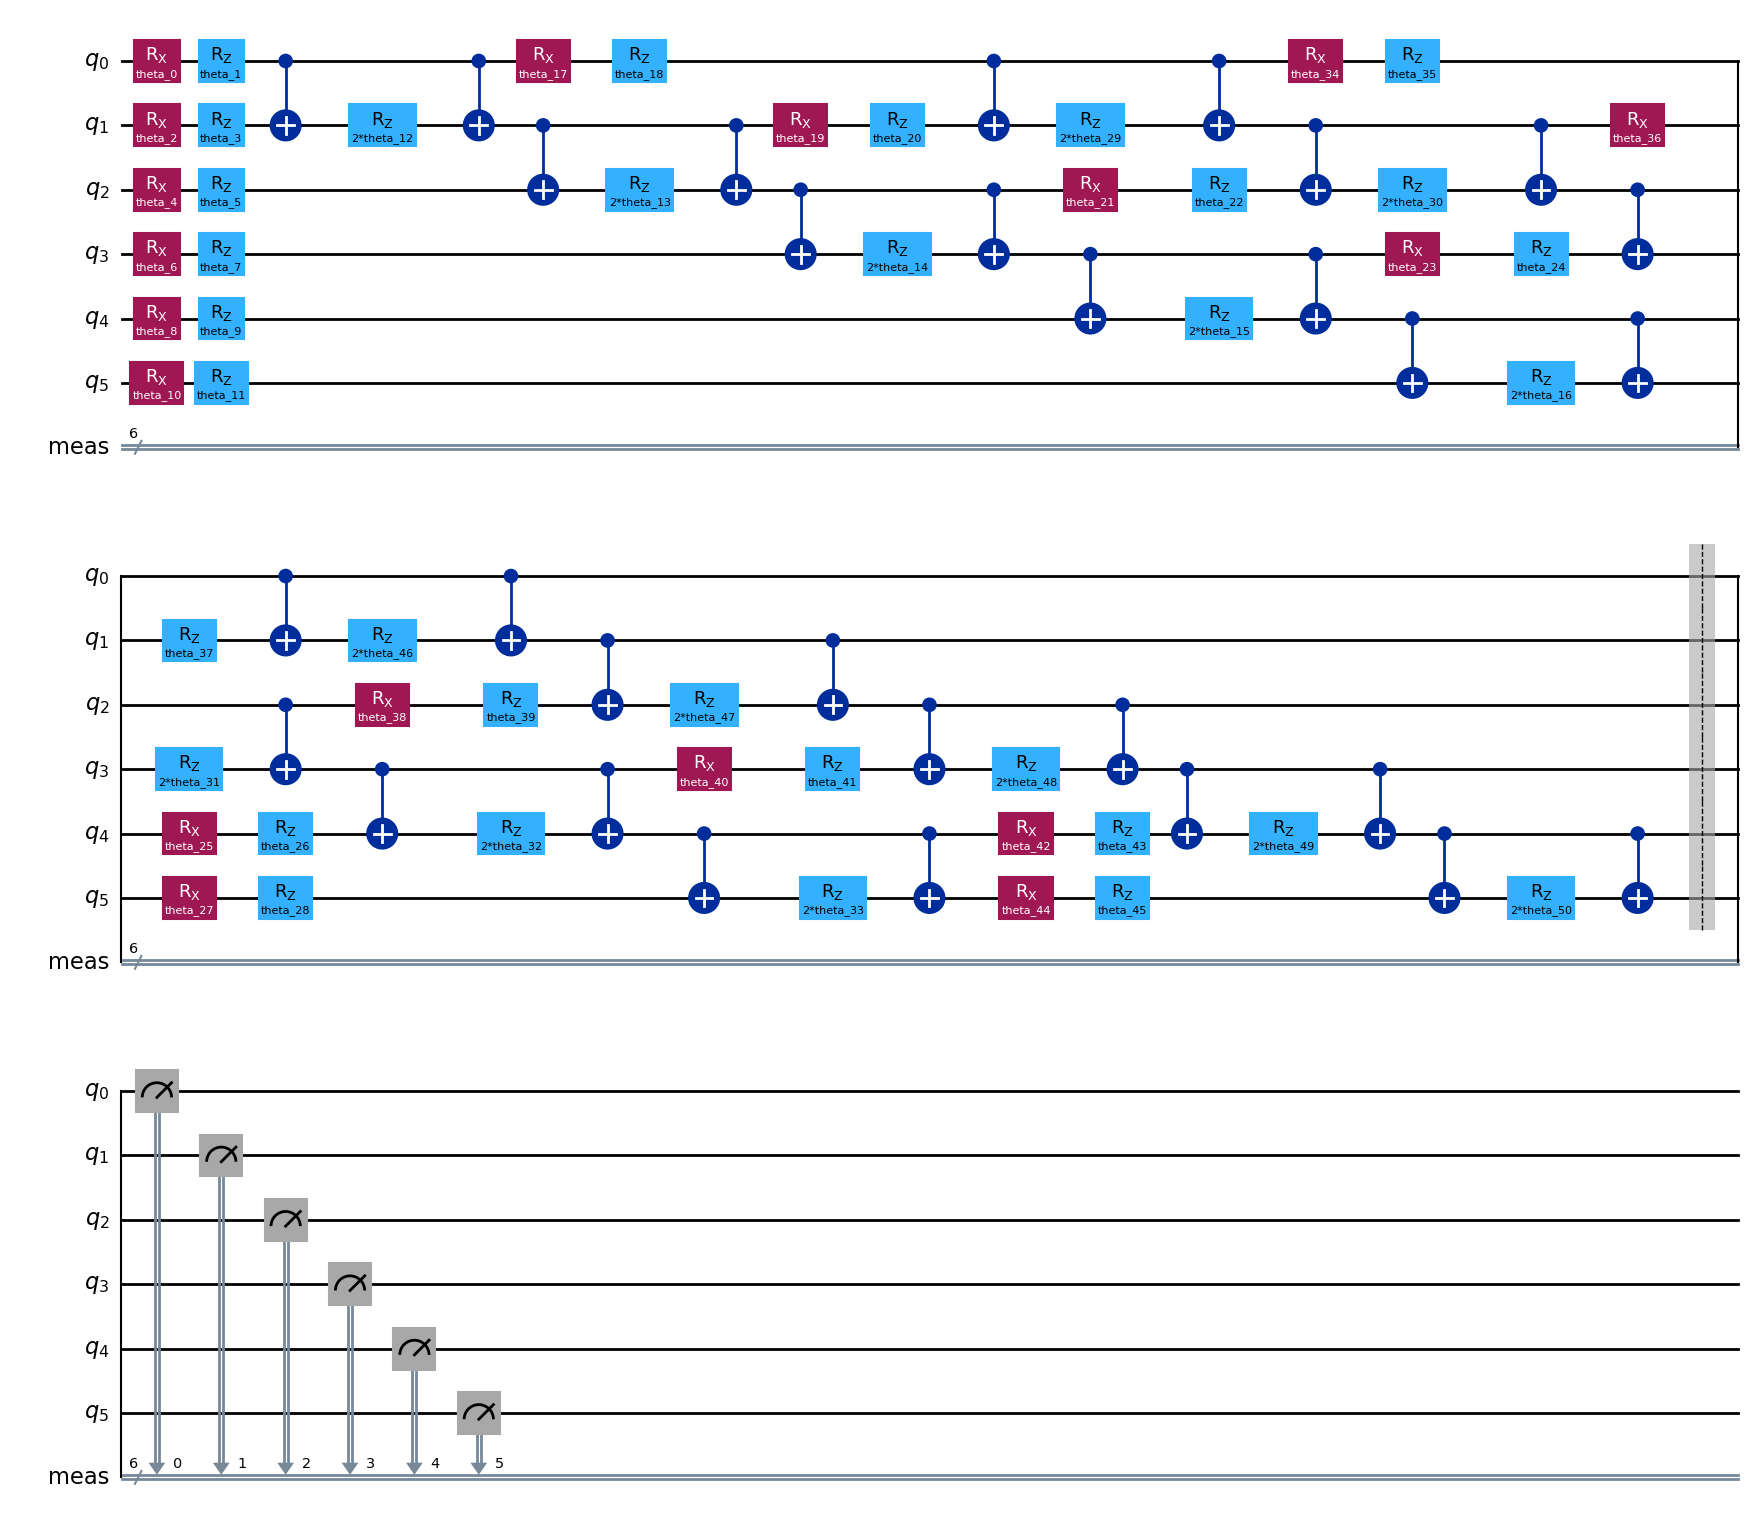

In [3]:
ansatz.draw_circuit()

In [3]:

# Start a session
n_epochs = 3
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    sampler.options.resilience_level = 2
    sampler.options.optimization_level = 3
    sampler.options.num_randomizations = 32
    sampler.options.shots_per_randomization = 100
    sampler.options.execution.shots = 1024 
    sampler.options.error_mitigation = {"method": "zne"}
    result = qcbm.train_on_batch(X, Y, sampler, backend, n_epochs)
    num_samples = 1000
    unique_samples, probabilities = qcbm.generate(num_samples, sampler, backend)
    qcbm.save_params("hw_param_train_4_qubits_3_layer_linear.json")
    for sample, prob in zip(unique_samples, probabilities):
        print(f"Sample: {sample}, Probability: {prob}")



/var/folders/01/9cxlhzln35j3j4d6wdv8jmmw0000gp/T/ipykernel_86905/2783166888.py:4: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)
Training Epochs:   0%|          | 0/3 [00:00<?, ?it/s]


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    1   F = 4.396834E+00    MAXCV = 0.000000E+00
   X =-1.024919E-01  -7.228980E-01  -1.378475E+00  -7.843126E-01  -4.193237E-01
       1.235055E+00   9.562771E-01   1.547673E+00   1.482506E-02  -3.448914E-01
      -8.834086E-02   6.639519E-01  -2.652845E-01  -1.328368E+00  -1.167535E+00
      -2.626277E-01  -4.387517E-01  -1.200547E+00  -7.195169E-01  -4.198222E-01
      -6.597080E-01   5.192502E-01  -9.212608E-01   5.543167E-01   1.288030E+00
       1.368733E+00   1.062955E+00   1.278264E+00   1.530201E+00   1.456567E+00
      -1.558497E+00  -4.489480E-01   2.146708E-01  -1.401916E+00   1.141020E+00
      -4.994280E-01   3.705434E-01  -1.539460E+00   1.290316E+00   6.189000E-01
       7.285126E-01  -1.176516E+00  -4.429216E-01  -7.920038E-01   1.220340E+00
       1.523335E+00  -2.602288E-02  -6.203704E-01  -9.973811E-01  -1.438645E+00
      -6.386528E-01


Training Epochs:  33%|███▎      | 1/3 [02:57<05:54, 177.35s/it, loss=4.4]


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    1   F = 4.393954E+00    MAXCV = 0.000000E+00
   X =-1.024919E-01  -7.228980E-01  -1.378475E+00  -7.843126E-01  -4.193237E-01
       1.235055E+00   9.562771E-01   1.547673E+00   1.482506E-02  -3.448914E-01
      -8.834086E-02   6.639519E-01  -2.652845E-01  -1.328368E+00  -1.167535E+00
      -2.626277E-01  -4.387517E-01  -1.200547E+00  -7.195169E-01  -4.198222E-01
      -6.597080E-01   5.192502E-01  -9.212608E-01   5.543167E-01   1.288030E+00
       1.368733E+00   1.062955E+00   1.278264E+00   1.530201E+00   1.456567E+00
      -1.558497E+00  -4.489480E-01   2.146708E-01  -1.401916E+00   1.141020E+00
      -4.994280E-01   3.705434E-01  -1.539460E+00   1.290316E+00   6.189000E-01
       7.285126E-01  -1.176516E+00  -4.429216E-01  -7.920038E-01   1.220340E+00
       1.523335E+00  -2.602288E-02  -6.203704E-01  -9.973811E-01  -1.438645E+00
      -6.386528E-01


Training Epochs:  67%|██████▋   | 2/3 [04:20<02:02, 122.09s/it, loss=4.37]


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    1   F = 4.410302E+00    MAXCV = 0.000000E+00
   X =-1.024919E-01  -7.228980E-01  -1.378475E+00  -7.843126E-01  -4.193237E-01
       1.235055E+00   9.562771E-01   1.547673E+00   1.482506E-02  -3.448914E-01
      -8.834086E-02   6.639519E-01  -2.652845E-01  -1.328368E+00  -1.167535E+00
      -2.626277E-01  -4.387517E-01  -1.200547E+00  -7.195169E-01  -4.198222E-01
      -6.597080E-01   5.192502E-01  -9.212608E-01   5.543167E-01   1.288030E+00
       1.368733E+00   1.062955E+00   1.278264E+00   1.530201E+00   1.456567E+00
      -1.558497E+00  -4.489480E-01   2.146708E-01  -1.401916E+00   1.141020E+00
      -4.994280E-01   3.705434E-01  -1.539460E+00   1.290316E+00   6.189000E-01
       7.285126E-01  -1.176516E+00  -4.429216E-01  -7.920038E-01   1.220340E+00
       1.523335E+00  -2.602288E-02  -6.203704E-01  -9.973811E-01  -1.438645E+00
      -6.386528E-01


Training Epochs: 100%|██████████| 3/3 [05:45<00:00, 115.31s/it, loss=4.37]


Sample: [0 0 0 0 0 0], Probability: 0.008
Sample: [0 0 0 0 0 1], Probability: 0.005
Sample: [0 0 0 0 1 0], Probability: 0.002
Sample: [0 0 0 0 1 1], Probability: 0.002
Sample: [0 0 0 1 0 0], Probability: 0.027
Sample: [0 0 0 1 0 1], Probability: 0.028
Sample: [0 0 0 1 1 0], Probability: 0.007
Sample: [0 0 0 1 1 1], Probability: 0.014
Sample: [0 0 1 0 0 0], Probability: 0.031
Sample: [0 0 1 0 0 1], Probability: 0.03
Sample: [0 0 1 0 1 0], Probability: 0.014
Sample: [0 0 1 0 1 1], Probability: 0.02
Sample: [0 0 1 1 0 0], Probability: 0.015
Sample: [0 0 1 1 0 1], Probability: 0.018
Sample: [0 0 1 1 1 0], Probability: 0.002
Sample: [0 0 1 1 1 1], Probability: 0.011
Sample: [0 1 0 0 0 0], Probability: 0.009
Sample: [0 1 0 0 0 1], Probability: 0.008
Sample: [0 1 0 0 1 0], Probability: 0.007
Sample: [0 1 0 0 1 1], Probability: 0.006
Sample: [0 1 0 1 0 0], Probability: 0.035
Sample: [0 1 0 1 0 1], Probability: 0.039
Sample: [0 1 0 1 1 0], Probability: 0.007
Sample: [0 1 0 1 1 1], Probability: 

In [34]:
for sample, prob in zip(unique_samples, probabilities):
    print(f"Sample: {sample}, Probability: {prob}")

Sample: [0 0 0 0 0 0], Probability: 0.016
Sample: [0 0 0 0 0 1], Probability: 0.042
Sample: [0 0 0 0 1 0], Probability: 0.045
Sample: [0 0 0 0 1 1], Probability: 0.029
Sample: [0 0 0 1 0 0], Probability: 0.015
Sample: [0 0 0 1 0 1], Probability: 0.026
Sample: [0 0 0 1 1 0], Probability: 0.036
Sample: [0 0 0 1 1 1], Probability: 0.023
Sample: [0 0 1 0 0 0], Probability: 0.012
Sample: [0 0 1 0 0 1], Probability: 0.021
Sample: [0 0 1 0 1 0], Probability: 0.026
Sample: [0 0 1 0 1 1], Probability: 0.019
Sample: [0 0 1 1 0 0], Probability: 0.004
Sample: [0 0 1 1 0 1], Probability: 0.007
Sample: [0 0 1 1 1 0], Probability: 0.011
Sample: [0 0 1 1 1 1], Probability: 0.006
Sample: [0 1 0 0 0 0], Probability: 0.016
Sample: [0 1 0 0 0 1], Probability: 0.035
Sample: [0 1 0 0 1 0], Probability: 0.035
Sample: [0 1 0 0 1 1], Probability: 0.021
Sample: [0 1 0 1 0 0], Probability: 0.007
Sample: [0 1 0 1 0 1], Probability: 0.017
Sample: [0 1 0 1 1 0], Probability: 0.023
Sample: [0 1 0 1 1 1], Probability

In [29]:
qcbm.save_params("param_4_4.json")

In [30]:
qcbm.load_params("param_4_4.json")

ToDO 
1. benchmark cardinality constrain
2. implement the architucture that i explained in the notebook

